In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import folium
#import json
from ipywidgets import IntSlider, interact
from scipy import stats
import geopandas as gpd
import pandas_bokeh
from bokeh.plotting import figure, output_file, save
pandas_bokeh.output_notebook()

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import umap

# Analysis of fertilizer effect on agriculture production
## Handling data
First let's import the 2 dataset from FAO:
* One about agriculture production containing (among others data) the yield per crops category and per country: Crops from http://www.fao.org/faostat/en/#data/QC
* The other about fertilizer containing quantity used of 3 different fertilizers per area of cropland (from 2002 to 2016): Fertilizers indicators from http://www.fao.org/faostat/en/#data/EF 

In [78]:
#importing needed FAO datasets
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

### 1) Fertilizer
Let's take a look at the fertilizer dataset and the type of data it contains

In [5]:
fertilizer_area.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2003,2003,kg/ha,2.57,Fc
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2004,2004,kg/ha,2.96,Fc


In [6]:
# range of year covered by fertilizer dataframe
mini=min(fertilizer_area.Year)
maxi=max(fertilizer_area.Year)
print('Period of time covered by fertilizer_area: %d to %d'%(mini,maxi))

Period of time covered by fertilizer_area: 2002 to 2016


In [7]:
# different types of fertilizers (and associated codes)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [9]:
# number of countries in the fertilizer dataset
fertilizer_area.Area.unique().size

197

In [10]:
# Checking the presence of missing values
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


So far, we don't observe any missing value.

However, as we will do an analysis over the years, let's take a look at the pivoted dataframe for the first fertilizer (Nutrient nitrogen N (total)):

In [14]:
ferti_corr=fertilizer_area.query('`Item Code` ==3102')\
                          .pivot(index='Area',columns='Year',values='Value')

print('Verification: number of countries:',ferti_corr.shape[0],', number of years:', ferti_corr.shape[1])
ferti_corr.head()

Verification: number of countries: 197 , number of years: 15


Year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,3.02,2.57,2.96,3.17,6.20,3.57,2.94,4.45,4.19,6.31,27.58,14.45,11.71,11.71,11.71
Africa,11.37,12.49,12.98,12.63,11.34,11.19,12.83,11.21,13.42,12.49,11.99,13.34,14.27,13.37,14.11
Albania,54.34,53.15,51.19,55.94,42.57,44.38,40.39,48.13,48.48,52.74,49.95,44.11,44.13,52.87,60.98
Algeria,3.42,2.07,12.62,0.49,5.23,4.37,2.75,5.69,8.43,7.51,7.89,7.79,12.25,11.83,11.53
Americas,44.75,48.24,47.61,46.88,48.52,52.89,48.92,49.66,53.46,60.11,59.68,59.44,58.48,57.26,60.90


Pivoting the dataframe will create missing values if the fertilizer value of a country is missing for any year. Let's look at it:

In [18]:
# Checking the number of missing values per year
print(ferti_corr.isna().sum())

Year
2002    19
2003    14
2004    10
2005    10
2006    10
2007    10
2008    10
2009     8
2010     8
2011     8
2012     4
2013     3
2014     3
2015     3
2016     4
dtype: int64


From the previous table, we can see that some values are missing for each year (we considered only nitrogen nutrient here). 
We can see that more values are missing for older years and that there are less than 10% of the values (197 countries) which are missing.
Thus, interpolation could be a realistic to fill these missing values.

However, in order to execute a linear interpolation, we need to verify that the evolution is effectively linear:

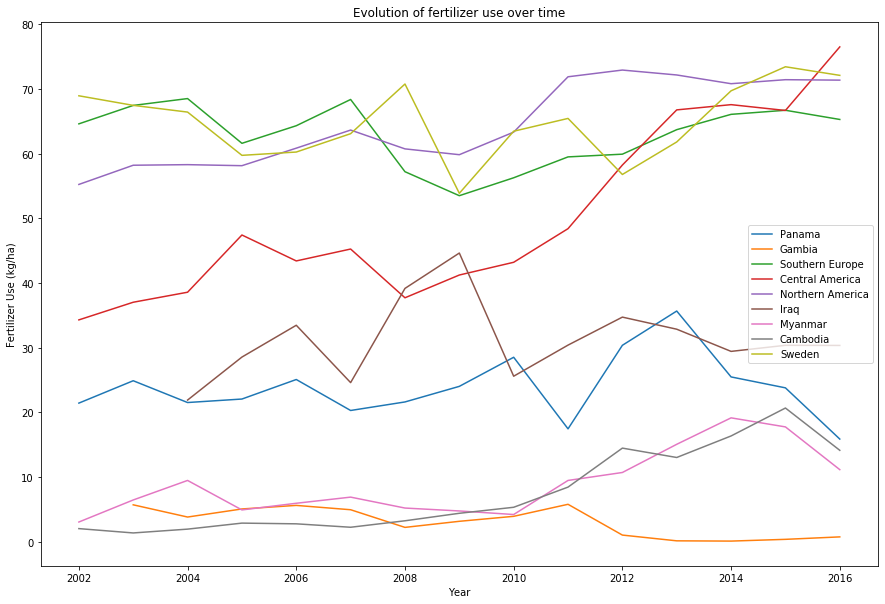

In [21]:
# Visually check the fertilizer evolution over the years
fig = plt.figure(figsize = (15, 10))
for area in fertilizer_area.sample(n=10).Area.unique()[:10]: #take randomly 10 countries in the dataset
    a=fertilizer_area.query('Area == @area and `Item Code`==3102')
    x=a.Year
    y=a.Value
    plt.plot(x,y, label = area)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Fertilizer Use (kg/ha)')
    plt.title('Evolution of fertilizer use over time')

The previous plot confirm that ferlizers can be interpolated using linear function as the order of magnitude stay the same and that the evolution look quite linear.

Let's perform the interpolation, except for countries with more than half of the years missing. We will drop them instead.

In [22]:
# Create a dataframe containing all the Area Code for each country
area_df=fertilizer_area.loc[:,['Area','Area Code']]
area_df.drop_duplicates(inplace=True)

# Perform the interpolation for each fertilizer:
fertilizer_updated = pd.DataFrame()
for item in ferti_items['Item Code'].values:
    ferti_corr=fertilizer_area.query('`Item Code` ==@item')\
                              .pivot(index='Area',columns='Year',values='Value')
    
    ferti_corr.interpolate(method='linear', axis=1, limit=7, inplace=True, limit_direction='both')
    ferti_corr.dropna(inplace=True)
    ferti_corr.reset_index(inplace=True)
    ferti_corr = pd.melt(ferti_corr, id_vars='Area', value_vars=list(ferti_corr.columns[1:]), 
                         var_name='Year', value_name='Value')
    ferti_corr['Item Code'] = item
    ferti_corr['Item'] = ferti_items.query('`Item Code`== @item').Item.iloc[0]
    ferti_corr['Year Code'] = ferti_corr.Year
    ferti_corr = pd.merge(ferti_corr, area_df, on='Area')
    fertilizer_updated = fertilizer_updated.append(ferti_corr)

fertilizer_updated.reset_index(inplace=True)
fertilizer_updated.drop(columns=['index'],axis=1,inplace=True)
fertilizer_updated.head()

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2


In [23]:
# Check for remaining missing values
ferti_corr2=fertilizer_updated.query('`Item Code` ==3102')\
                              .pivot(index='Area',columns='Year',values='Value')

print(ferti_corr2.isnull().sum())

Year
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
dtype: int64


In [24]:
#Updating the main fertilizer dataset
fertilizer_area = fertilizer_updated
fertilizer_area.head()

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2


## 2) Crop dataset
We decided to use grouped yields to reduce risks of collinearity in the dataset (grouped crops are more likely to regroup all dependent features together).

First, let's take a look at the yields for each country in 2004 (arbitrarily selected):

In [79]:
#extract of yield in the crop dataset and pivot to obtain a dataframe with yields as columns (features) and countries as rows
crop_corr=(crops.query('`Element Code` == 5419') #The element code of yield is 5419
                .query('`Year Code` == 2004')
                .query('`Item Code` >1000') #grouped yields correspond to item codes > 1000
                .pivot(index='Area',columns='Item',values='Value')
                .reset_index())

print('There are', crop_corr.shape[0], 'countries and', crop_corr.shape[1]-1,'yields in the dataset.')
crop_corr.head()

There are 244 countries and 12 yields in the dataset.


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


We can see that there are some missing value (either due to missing values in the crops dataset or to unproduced crops by a country).
How many are there?

In [80]:
# Count massing values per crops category in 2004
print(crop_corr.isna().sum()[crop_corr.isna().sum()!=0])

Item
Cereals (Rice Milled Eqv)     27
Cereals,Total                 27
Citrus Fruit,Total            72
Coarse Grain, Total           31
Fibre Crops Primary           90
Fruit Primary                  6
Oilcrops, Cake Equivalent     18
Oilcrops, Oil Equivalent      16
Pulses,Total                  39
Roots and Tubers,Total         7
Treenuts,Total               100
Vegetables Primary             6
dtype: int64


We can expand that analysis for all years:

In [81]:
# count total number of missing values for all years
miss_count=pd.DataFrame()
for year in year_range:    
    crop_year = (crops.query('`Element Code` == 5419') #select the yields
                      .query('`Year Code` == @year') #select the year
                      .query('`Item Code` >1000') #select the group yields
                      .query('`Area Code` <300') #deselect the group of countries (such as Africa, America, ...)
                      .pivot(index='Area Code',columns='Item',values='Value')
                      .reset_index())
    
    keys = ['Total number of rows'] + crop_year.columns.values.tolist()[1:]
    values = [crop_year.shape[0]] + crop_year.isna().sum().values.tolist()[1:] #count the missing values
    dictionary = dict(zip(keys, values))
    df = pd.DataFrame.from_records([dictionary])
    miss_count = miss_count.append(df,sort=False)
    
print(miss_count.sum())
print('There are',miss_count.sum()[1:].sum(), 'missing values in total')

Total number of rows         3149.0
Cereals (Rice Milled Eqv)     389.0
Cereals,Total                 389.0
Citrus Fruit,Total           1063.0
Coarse Grain, Total           448.0
Fibre Crops Primary          1154.0
Fruit Primary                  88.0
Oilcrops, Cake Equivalent     229.0
Oilcrops, Oil Equivalent      194.0
Pulses,Total                  554.0
Roots and Tubers,Total        103.0
Treenuts,Total               1486.0
Vegetables Primary             88.0
dtype: float64
There are 6185.0 missing values in total


Treenuts, Fibre Crops Primary and Citrus Fruit,Total presents 3703 missing values, 60% of the total number of missing values.

## Interpolating to replace missing values
Interpolation contains 4 steps:

- Creating 2 datasets: the first one will contain rows with missing values. In the second one, missing values will be dropped. This dataset will be the recipient of the interpolated values.
- Interpolate missing values from the second dataset (except when there are too much missing values as in the fertilizer interpolation)
- Add these missing values in the initial crops dataset
- Check for remaining missing values

1) creating the 2 datasets

In [82]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [83]:
year_range=pd.Series(range(2002,2016+1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=year_range[~year_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()
        

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [84]:
print('There are',missing_values.shape[0],'rows with missing values')

There are 2807 rows with missing values


In [85]:
# Creating the 2nd dataset
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

2) Executing the interpolation:

In [86]:
'''count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x').Item.unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value = poly(year)
                template = (dropnan_crops.query('`Area Code` == @x')
                                        .query('`Item` == @j').head(1))
                to_add = template.values
                to_add[0][9] = interp_value
                to_add[0][6] = year
                to_add[0][7] = year
                to_add=pd.DataFrame(to_add, columns=template.columns.values)
                crops=crops.append(to_add, ignore_index=True, sort=False)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print("The operation replaced %d values"%count)
'''

'count=0\n#Purpose of this code : adding missing value by interpolation \nfor x in missing_values[\'Area Code\'].unique():\n    for j in missing_values.query(\'`Area Code` == @x\').Item.unique():\n        if dropnan_crops.query(\'`Area Code` == @x\').query(\'`Item` == @j\').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values\n            interpolation_coef = np.polyfit(dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Year,\n                                            dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Value,\n                                            1)\n            poly = np.poly1d(interpolation_coef)\n            for year in missing_values.query(\'`Area Code` == @x\').query(\'`Item` == @j\').Year.values:\n                interp_value = poly(year)\n                template = (dropnan_crops.query(\'`Area Code` == @x\')\n                                        .query(\'`Item` == @j\').head(1)

#### Saving modified crops to avoid re-running the interpolation

In [87]:
#crops.to_pickle("crops_interpolated") # uncomment to save again into pickle

In [88]:
crops=pd.read_pickle("crops_interpolated")

In [89]:
# Reset index to avoid index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


3) Checking changed values 

In [90]:
# count number of replaced values
area_indexed2=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed2.shape[0]-area_indexed.shape[0]

1371

Let's take a look at how many missing values have been replaced :

In [91]:
year_range=pd.Series(range(2002,2016+1))
missing_values2=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed2.index.get_level_values(level=0).unique().values:
    for item in area_indexed2.loc[area].index.unique().values:
        year_missing=year_range[~year_range.isin(area_indexed2.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values2 =missing_values2.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
miss_count2=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Total number of rows']+crop_year.columns.values.tolist()[1:]
    values=[crop_year.shape[0]]+np.round(crop_year.isnull().sum().values).tolist()[1:]
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count2=miss_count2.append(df, sort=False)
print(miss_count2.sum())
print('There are',miss_count2.sum()[1:].sum(), 'missing values in total')

Total number of rows         3184
Cereals (Rice Milled Eqv)     390
Cereals,Total                 390
Citrus Fruit,Total           1065
Coarse Grain, Total           450
Fibre Crops Primary          1346
Fruit Primary                  90
Oilcrops, Cake Equivalent     279
Oilcrops, Oil Equivalent      234
Pulses,Total                  555
Roots and Tubers,Total        105
Treenuts,Total               1500
Vegetables Primary             90
dtype: int64
There are 6494 missing values in total


In [92]:
print(miss_count.sum())
print('There are',miss_count.sum()[1:].sum(), 'missing values in total')

Total number of rows         3149.0
Cereals (Rice Milled Eqv)     389.0
Cereals,Total                 389.0
Citrus Fruit,Total           1063.0
Coarse Grain, Total           448.0
Fibre Crops Primary          1154.0
Fruit Primary                  88.0
Oilcrops, Cake Equivalent     229.0
Oilcrops, Oil Equivalent      194.0
Pulses,Total                  554.0
Roots and Tubers,Total        103.0
Treenuts,Total               1486.0
Vegetables Primary             88.0
dtype: float64
There are 6185.0 missing values in total


Our first dataset (before the interpolation) has less missing values than the second one. Some rows have been added to the second one, explaining thus the difference.

Let's take a look at number of missing values by column and year for both cases:

In [97]:
miss_count2-miss_count

,Total number of rows,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,4,0,0,-1,0,2.0,0,1.0,0.0,-1,0,-1,0
0,4,0,0,-1,0,3.0,0,1.0,0.0,0,0,-1,0
0,4,0,0,1,0,3.0,0,1.0,0.0,0,0,1,0
0,4,0,0,1,0,3.0,0,1.0,0.0,0,0,1,0
0,2,-1,-1,0,0,0.0,0,1.0,1.0,0,0,1,0
0,2,0,0,0,0,1.0,0,1.0,1.0,0,0,1,0
0,2,0,0,0,0,0.0,0,1.0,1.0,0,0,2,0
0,2,0,0,0,0,1.0,0,1.0,1.0,0,0,2,0
0,2,0,0,0,0,1.0,0,2.0,2.0,0,0,2,0
0,2,0,0,0,0,1.0,0,2.0,2.0,0,0,2,0


One can notice from the table that there were 3 columns with NaN value. This is due to complete absence of data for these crops for 2015 and 2016. 

Hence, the interpolation program extrapolated for these two years and thus replaced NaN values by missing values in the previous tables. This explains the extra missing values in the last dataset.

Moreover, the extrapolation replaced missing features for the two last years allowing us to carry out machine learning on all years (as we have all features for each years) and to compare results within years. 

Finally, as we have a big proportion of the countries with missing values for "Treenuts", "Fibre Crops Primary" and "Citrus Fruit,Total", we will drop these features during the next part.

### Correlation between crops production

For an efficient use of machine learning algorithms, it is better to work with independant features. Therefore, let's take a look at the correlation heatmap between features:

Text(0.5, 1, 'Correlation matrix for the yields')

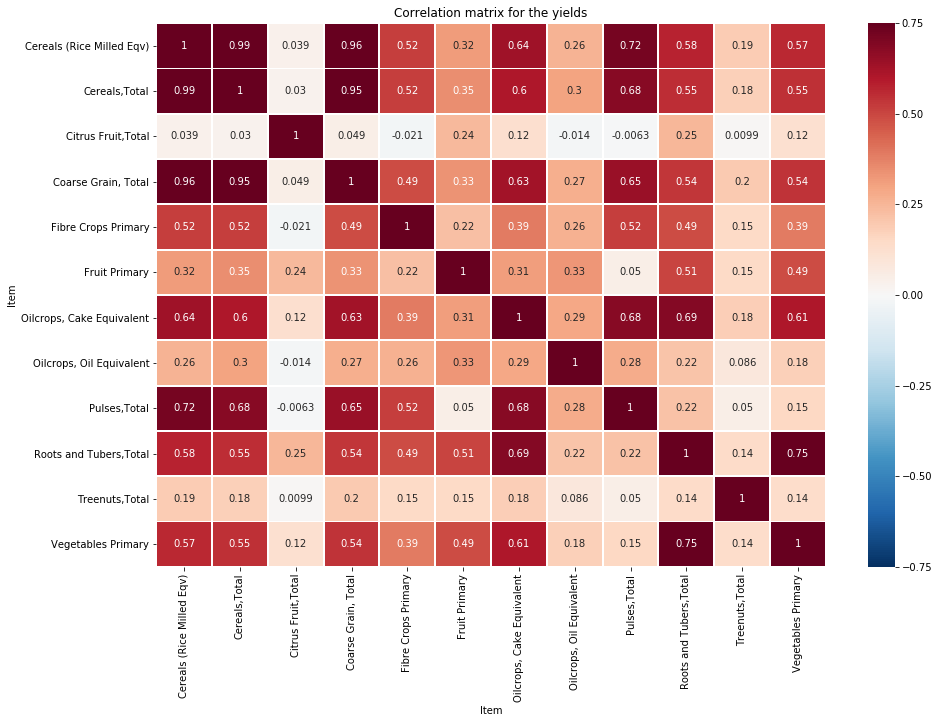

In [98]:
# correlation for the year 2004
correlation = crop_corr.corr()

# Plotting correlation map
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(correlation, annot=True, linewidths=1, center=0,\
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
plt.title("Correlation matrix for the yields")

We can see that cereals are strongly correlated. Thus, we will merge them.

## Dimensionality reduction 

We don’t have the amount of fertilizer by category of crops, but only the value of the global use of fertilizers is provided. Thus,to properly compare yields and fertilizers, we need to construct a global value representing as well as possible all the complete agriculture of a country, i.e. reduce all the yields of a country to one indicator.

To do so, we preferred to use dimensionality reduction methods rather than a simple sum because of their better ability to maintain the distance information between objects (here, countries).

2 different algorithms for dimensionality reduction will be used:
* Umap because it can capture non-linear relations
* PCA because it gives us information about the importance of each feature through coefficients


### Umap reduction

In [102]:
# This function separates countries into three different groups according to their fertilizer use
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizer values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

Definition ot the function calculating the umap reduction:

Inputs: year, 1 fertilizer code and number of final dimension(s).

Outputs: computed year, a dataframe with Umap score as well as fertilizer value for each country and coefficient from a linear interpolation of the result (fertilizer value vs umap score)


In [107]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .query('Value > 0')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Now that the function is defined, let's take a look at the relationship between fertilizer use and umap projection over the year. The linear interpolation is also plotted.

C:\Users\victo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\victo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\victo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\victo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\victo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to

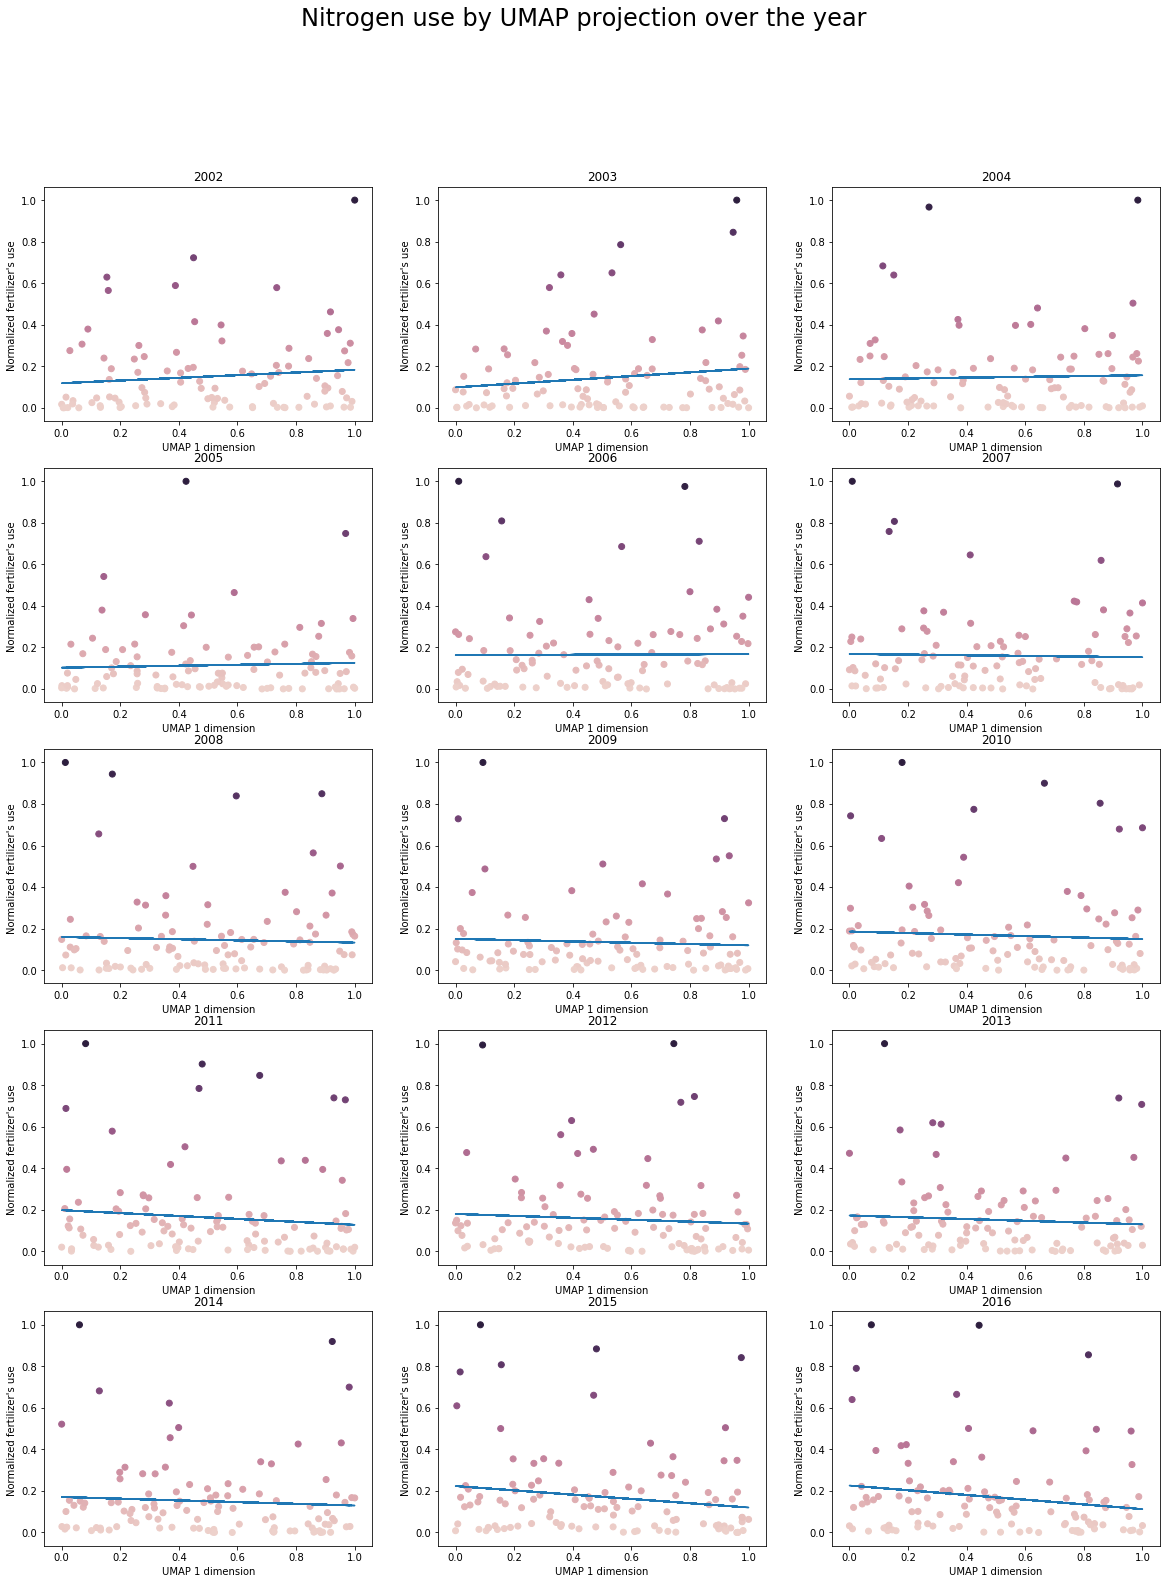

In [108]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3103, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2['Umap'], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2['Umap'], poly1d_fn(embedding2['Umap']))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

The correlation between Umap and fertilizer use is weak. We will therefore not explore this tool anymore.

PCA